In [1]:
from pyspark import SparkContext, SparkConf
from pyspark import HiveContext
from pyspark.sql import SQLContext
import datetime
import pandas as pd
import numpy as np
import random
np.random.seed(5)
confs = SparkConf()
confs.set("spark.driver.maxResultSize","15g")
confs.set("spark.driver.memory","30g")
confs.set("spark.dynamicAllocation.enabled","true")
confs.set("spark.dynamicAllocation.minExecutors","1")
confs.set("spark.dynamicAllocation.maxExecutors","600")
confs.set("spark.task.maxFailures","15")
confs.set("spark.yarn.max.executor.failures","1000")
confs.set("spark.dynamicAllocation.executorIdleTimeout","400")
confs.set("spark.shuffle.service.enabled","true")
confs.set("spark.executor.cores","1")
confs.set("spark.executor.memory","8g")
confs.set("spark.network.timeout","240000")
confs.set("spark.akka.frameSize","512")
confs.set("spark.yarn.dist.archives","hdfs://cls04pri/user/vvelocci/RoutesNYC.zip#anaconda")
sc = SparkContext(conf=confs,master="yarn-client")                               
hc = HiveContext(sc)

In [2]:
import pickle
from shapely.geometry import shape, Point, asShape
import fiona
from operator import add
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict

In [3]:
# POI List for Missouri
poi = sc.textFile("hdfs://cls04pri/user/vvelocci/IYP_MO.afi.txt")

In [4]:
poi2 = poi.map(lambda x: x.split('|')) # dataset is rows of text with data separated by those pipes
def clean(x):
    y = filter(lambda a: a != '', x)
    return y
poi3 = poi2.map(clean)

In [5]:
def lat_long_present(poi):
    """
    Returns True if there is a lat and long present
    Otherwise, returns False
    """
    for entry in poi:
        try:
            y = float(entry)
            if y < 0: # longitude detected
                return True
        except:
            continue
    return False

def find_lat_long(poi):
    """
    Returns the latitude, longitude, index of latitude
    and index of longitude
    """
    for entry in poi:
        try:
            y = float(entry)
            if y < 0:
                la = poi.index(entry) - 1
                latitude, longitude, index_la, index_lo =  float(poi[la]), float(entry), la, poi.index(entry)
                return latitude, longitude, index_la, index_lo
        except:
            continue
            
def find_all_8(poi):
    """
    Finds all 8 digit integers, returns them and
    their indices.  There might be an 8-digit number
    that is not a date at positions 0 and 1.  We don't want those.
    """
    i = 2
    numbers = []
    indices = []
    end_year = 2017
    for entry in poi[2:]:
        try:
            y = int(entry)
            if len(entry) == 8:
                numbers.append(entry)
                indices.append(i)
            i += 1
        except:
            i += 1
            continue
    return numbers, indices

def find_8(poi):
    """
    Finds all 8 digit integers that are not dates, returns them and
    their indices.  There might be an 8-digit number
    that is not a date at positions 0 and 1.  We don't want those.
    """
    i = 2
    indices = []
    sics = []
    end_year = 2017
    for entry in poi[2:]:
        try:
            y = int(entry)
            if len(entry) == 8 and not any(x in entry[:4] for x in [str(y) for y in range(1980, end_year + 1)]):
                indices.append(i)
                sics.append(entry)
            i += 1
        except:
            i += 1
            continue
    return indices, sics

def find_4(poi, indices_8):
    """
    Finds the 4-digit primary sic code
    """
    try:
        first = min(indices_8)
        for i in range(first-1, 2, -1):
            try:
                y = int(poi[i])
                if len(poi[i]) == 4:
                    return poi[i]
                else:
                    continue
            except:
                continue
        # If it doesn't exist, then just use the first 4 digits of the first
        # 8-digit sic code
        return poi[first][:4]
    except:
        return 'no_4_digit_sic'
        
def find_single(poi):
    """
    Finds all upper case strings of length 1
    returns their indices
    """
    i = 1
    indices = []
    for entry in poi[1:]:
        try:
            y = float(entry)
            i += 1
            continue
        except:
            if len(entry) == 1 and entry.isupper():
                indices.append(i)
                i += 1
            else:
                i += 1
    return indices

def beginning_info(poi):
    """
    Finds name/description of poi near beginning of the row
    (used if it does not exist after the latitude and longitude)
    """
    m = poi.index('MO')
    pre = poi[:m-1]
    for foo in pre:
        try:
            x = float(foo) # We don't want the numbers, we want the string that contains info we want
            continue
        except:
            title = foo # found the info
            end = []
            end.append(title) # append our info to lat and long
            return end
        
def find_industry_code(poi):
    """
    Finds the upper case letter code designating
    the industry/business type of the poi
    """
    indices_for_8, sics = find_8(poi)
    indices_for_1 = find_single(poi)
    code = 'U' # Code is Unknown
    candidates = []
    if indices_for_8:
        index_of_last_sic = indices_for_8[-1]
        l = range(index_of_last_sic + 1, len(poi))
        candidates = [i for i in indices_for_1 if i in l]
        if candidates:
            industry_index = min(candidates)
            code = poi[industry_index]
    return code, indices_for_8, sics

def keep(poi):
    """
    Returns latitude, longitude, poi info and industry code
    """
    crap = ['http', 'www.', '@', '.com', '.edu', '.org', '.net']
    user = poi[0]
    end = []
    lat, lon, index_lat, index_lon = find_lat_long(poi)
    end.extend([lat, lon])
    if len(poi[index_lat:]) >= 3 and not any(x in poi[index_lon + 1] for x in crap):
        end.append(poi[index_lon + 1])
        
    else:
        end.extend(beginning_info(poi))
    industry_code, indices_for_8, sics = find_industry_code(poi)
    sic4 = find_4(poi, indices_for_8)
    end.append(industry_code)
    end.append(sic4)
    #end.extend(sics)
    return (user, end)

In [6]:
poi4 = poi3.filter(lat_long_present)

In [7]:
# # The only years that coincide with the first 4 digits of sic codes are 2011, 2013, and 2015.
# # Count the number of poi's that have any of these years in the first 4 digits of their sic codes.
# # Answer = 0.  Therefore, we may remove all 8 digit numbers that begin with years from 1980 - 2017 since
# # they don't correspond to sic codes, aside from 2011, 2013, and 2015, which aren't in the dataset anyway.
# rdd = poi4.map(find_all_8).filter(lambda x: any(j in x[0] for j in ['2011','2013','2015'])).count()

In [8]:
unknowns_mo = poi4.map(keep).filter(lambda x: x[1][3] == 'U')
# #unknowns_mo.count
# #31817 unknown codes in MO out of a total of 284656 poi's.  That's 11%.

In [9]:
#poi4.count()

In [10]:
known_mo = poi4.map(keep).filter(lambda x: x[1][3] != 'U').cache()

In [11]:
total_known = known_mo.count() # 252839

In [135]:
unknowns_mo.take(1)

[(u'3685',
  [38.941164,
   -94.603472,
   u'Miscellaneous Business Services',
   'U',
   'no_4_digit_sic'])]

In [136]:
known_mo.take(1)

[(u'2494', [37.8502, -90.5211, u'Mufflers & Exhaust Systems', u'I', 7539])]

In [12]:
code_count = known_mo.map(lambda x: (str(x[1][3]), 1)).reduceByKey(add).collect()
code_count = sorted(code_count, key = lambda x: x[0])
code_percent = [float(i[1])/total_known for i in code_count]
code_freq = [i[1] for i in code_count]
letters = [i[0] for i in code_count]

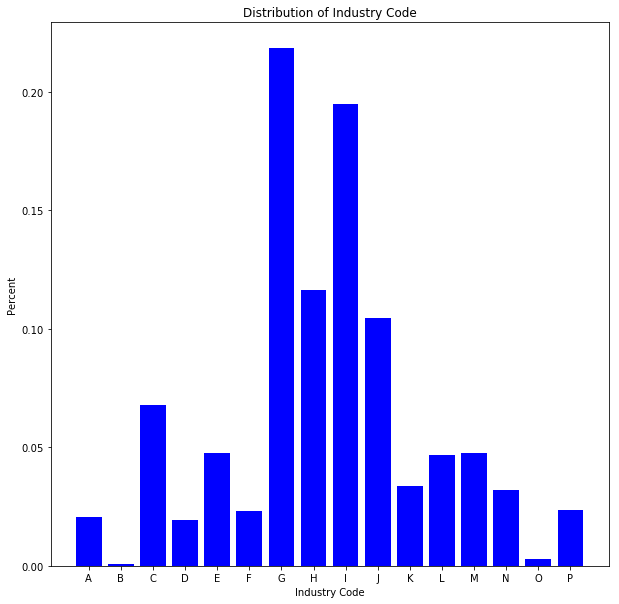

In [13]:
fig = plt.figure(figsize=(10,10))
axes = fig.add_subplot(1,1,1)
x = range(len(code_percent))
axes.bar(x, code_percent, align='center', color = 'blue')
axes.set_ylabel('Percent')
axes.set_xlabel('Industry Code')
axes.set_xticks(x)
axes.set_xticklabels(letters)
axes.set_title('Distribution of Industry Code');

In [77]:
#known_mo3 = known_mo2.groupByKey().map(lambda x : (x[0], list(x[1])))

In [14]:
from pyspark.mllib.feature import HashingTF, IDF, Normalizer, Word2Vec
from pyspark.mllib.classification import LogisticRegressionWithSGD, NaiveBayes, LogisticRegressionModel, LogisticRegressionWithLBFGS
from pyspark.mllib.linalg import Vectors, SparseVector, DenseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel, RandomForest, GradientBoostedTrees
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

In [15]:
#Most algorithms in MLlib are iterative, going over the data multiple times. Thus, it is important to cache() 
#your input datasets before passing them to MLlib. Even if your data does not fit in memory, try 
#persist(StorageLevel.DISK_ONLY).  In Python, MLlib automatically caches RDDs on the Java side when you pass 
#them from Python, so there is no need to cache your Python RDDs unless you reuse them within your program. 
#In Scala and Java, however, it is up to you to cache them.

In [15]:
labels_dict = dict(zip(letters, [float(x) for x in range(len(letters))])) # eg. D: 3.0
labels_dict2 = dict(zip([float(x) for x in range(len(letters))], letters)) # eg. 3.0: D

def labels2(x):
    # Convert class label from letter to float
    label = labels_dict[x[1][3]]
    return (x[0], x[1][0], x[1][1], x[1][2], label)

known_mo_new = known_mo.map(labels2)

# Create a dataframe from the known POI data
poiData = hc.createDataFrame(known_mo_new, ['id', 'lat', 'long', 'text', 'label'])

# Split dataframe aproximately into training (80%) and test (20%)
training, test = poiData.randomSplit([0.8, 0.2], seed = 0)

# Fit TFIDF feature vectors from the training set
tokenizer = Tokenizer(inputCol="text", outputCol="words")
wordsData = tokenizer.transform(training)
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")#, numFeatures=20)
featurizedData = hashingTF.transform(wordsData)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

def convert_to_labeled_point(row):
    # Makes a LabeledPoint out of a label and feature vector
    return LabeledPoint(row.label, row.features)

# Make labeled points from the training set so that Spark can use ML on the training set
data = rescaledData.map(convert_to_labeled_point)

# for features_label in rescaledData.select("features", "id").take(10):
#     print LabeledPoint(features_label.id, features_label.features)

# Use the TFIDF vectorizer to transform our test set
test_wordsData = tokenizer.transform(test)
test_featurizedData = hashingTF.transform(test_wordsData)
test_rescaledData = idfModel.transform(test_featurizedData)

# Make labeled points from the test set
test_data = test_rescaledData.map(convert_to_labeled_point)

In [16]:
# Train a naive Bayes model on the training set
model_nb = NaiveBayes.train(data, 2.0) # smoothing param of 2.0 gave best accuracy on testing dataset

# Use the model to make predictions on the test set and calculate accuracy
predictionAndLabel = test_data.map(lambda p : (float(model_nb.predict(p.features)), p.label))
accuracy_nb = 1.0 * predictionAndLabel.filter(lambda (x, v): x == v).count() / test.count()
accuracy_nb

metrics = MulticlassMetrics(predictionAndLabel)
[metrics.falsePositiveRate(i) for i in [float(j) for j in range(16)]]
[metrics.precision(i) for i in [float(j) for j in range(16)]]
[metrics.recall(i) for i in [float(j) for j in range(16)]]
[metrics.fMeasure(i) for i in [float(j) for j in range(16)]]
metrics.fMeasure()
# metrics.precision(1.0)
# metrics.recall(2.0)
# metrics.fMeasure(0.0, 2.0)
# metrics.precision()
# metrics.recall()
# metrics.fMeasure()

0.8873585350518705

In [17]:
unknowns_noLabel = unknowns_mo.map(lambda x: (x[0], x[1][0], x[1][1], x[1][2]))
unknown_poiData = hc.createDataFrame(unknowns_noLabel, ['id', 'lat', 'long', 'text'])
unknown_wordsData = tokenizer.transform(unknown_poiData)
unknown_featurizedData = hashingTF.transform(unknown_wordsData)
unknown_rescaledData = idfModel.transform(unknown_featurizedData)
def pred_data(row):
    return (row.id, [row.lat, row.long, row.text, row.features])
unknown_data = unknown_rescaledData.map(pred_data)
def letters(x):
    return (x[0], [x[1][0], x[1][1], x[1][2], x[1][3], labels_dict2[x[1][4]], 'need_4_digit_sic'])
predictionsForUnknowns = unknown_data.map(lambda p : (p[0], [p[1][0], p[1][1], p[1][2], p[1][3], float(model_nb.predict(p[1][3]))])).map(letters)
# def predictions(poi):
#     poi2 = labels2(poi)
#     poi2Data = hc.createDataFrame(poi2, ['id', 'lat', 'long', 'text', 'label'])
#     poi2_wordsData = tokenizer.transform(poi2Data)
#     poi2_featurizedData = hashingTF.transform(poi2_wordsData)
#     poi2_rescaledData = idfModel.transform(poi2_featurizedData)
#     predicted_label = float(model_nb.predict(poi2_rescaledData.features))
#     letter = labels_dict2[predicted_label]
#     return (poi[0], [poi[1][0], poi[1][1], poi[1][2], letter])

In [23]:
complete_sic_list = sc.textFile("complete_sic_list.txt")

In [60]:
def remove_crap(x):
    if x[1].endswith(', NOT ELSEWHERE CLASSIFIED'):
        x[1] = x[1][:-26]
    return [x[0], x[1]]
complete_sic_list2 = complete_sic_list.map(lambda x: x.split()).filter(lambda x: len(x) > 0).filter(lambda x: len(x[0]) == 4).map(lambda x: [x[0], ' '.join(x[1:])]).map(remove_crap)
#complete_sic_list3 = complete_sic_list2.map(remove_crap).collect()
complete_sic_list2.collect()

[[u'0111', u'WHEAT'],
 [u'0112', u'RICE'],
 [u'0115', u'CORN'],
 [u'0116', u'SOYBEANS'],
 [u'0119', u'CASH GRAINS'],
 [u'0131', u'COTTON'],
 [u'0132', u'TOBACCO'],
 [u'0133', u'SUGARCANE AND SUGAR BEETS'],
 [u'0134', u'IRISH POTATOES'],
 [u'0139', u'FIELD CROPS, EXCEPT CASH GRAINS'],
 [u'0161', u'VEGETABLES AND MELONS'],
 [u'0171', u'BERRY CROPS'],
 [u'0172', u'GRAPES'],
 [u'0173', u'TREE NUTS'],
 [u'0174', u'CITRUS FRUITS'],
 [u'0175', u'DECIDUOUS TREE FRUITS'],
 [u'0179', u'FRUITS AND TREE NUTS'],
 [u'0181', u'ORNAMENTAL FLORICULTURE AND NURSERY PRODUCTS'],
 [u'0182', u'FOOD CROPS GROWN UNDER COVER'],
 [u'0191', u'GENERAL FARMS, PRIMARILY CROP'],
 [u'0211', u'BEEF CATTLE FEEDLOTS'],
 [u'0212', u'BEEF CATTLE, EXCEPT FEEDLOTS'],
 [u'0213', u'HOGS'],
 [u'0214', u'SHEEP AND GOATS'],
 [u'0219', u'GENERAL LIVESTOCK, EXCEPT DAIRY AND POULTRY'],
 [u'0241', u'DAIRY FARMS'],
 [u'0251', u'BROILER, FRYER, AND ROASTER CHICKENS'],
 [u'0252', u'CHICKEN EGGS'],
 [u'0253', u'TURKEYS AND TURKEY EGGS']

In [64]:
codes = []
descri = []
foo = complete_sic_list2.collect()
for blah in foo:
    codes.append(blah[0])
    descri.append(blah[1])
complete_sic_dict = dict(zip(codes, descri))

In [67]:
with open('complete_sic_dict.pickle', 'wb') as handle:
    pickle.dump(complete_sic_dict, handle)

In [5]:
# Code using a SIC list from Wikipedia, which isn't as complete as the one I found and made into complete_sic_list
# sic_list = sc.textFile("sic_list.txt").map(lambda x: x.split('\t')).map(lambda x: [x[0], ' '.join(x[3:])])
# codes = []
# descri = []
# foo = sic_list.collect()
# for blah in foo:
#     codes.append(blah[0])
#     descri.append(blah[1])

# for code in codes:
#     if len(code) == 3:
#         i = codes.index(code)
#         codes[i] = '0'+codes[i]
# sic_dict = dict(zip(codes, descri))

# with open('sic_dict.pickle', 'wb') as handle:
#     pickle.dump(sic_dict, handle)
    
# sic_rdd = sc.parallelize([(k,v) for k,v in sic_dict.items()])
# sic_Data = hc.createDataFrame(sic_rdd, ['code', 'text'])
# sic_words = tokenizer.transform(sic_Data)
# sic_featurizedData = hashingTF.transform(sic_words)
# sic_rescaledData = idfModel.transform(sic_featurizedData)
# sic1 = sic_rescaledData.map(lambda row: (row.code, row.text, row.features))

# sic_list = sic1.collect()

# sic_list_dict = dict()
# for sic in sic_list:
#     sic_list_dict[sic[0]] = [sic[1], sic[2]]

In [68]:
complete_sic_rdd = sc.parallelize([(k,v) for k,v in complete_sic_dict.items()])
complete_sic_Data = hc.createDataFrame(complete_sic_rdd, ['code', 'text'])
complete_sic_words = tokenizer.transform(complete_sic_Data)
complete_sic_featurizedData = hashingTF.transform(complete_sic_words)
complete_sic_rescaledData = idfModel.transform(complete_sic_featurizedData)
complete_sic1 = complete_sic_rescaledData.map(lambda row: (row.code, row.text, row.features))

In [69]:
complete_sic_list = complete_sic1.collect()

In [70]:
complete_sic_list

[(u'7692',
  u'WELDING REPAIR',
  SparseVector(262144, {8077: 4.4139, 260444: 6.3158})),
 (u'3715',
  u'TRUCK TRAILERS',
  SparseVector(262144, {15455: 5.0236, 201120: 6.8176})),
 (u'6514',
  u'OPERATORS OF DWELLINGS OTHER THAN APARTMENT BUILDINGS',
  SparseVector(262144, {3543: 5.2488, 17471: 7.3482, 22322: 5.8789, 150945: 12.2157, 163600: 9.3825, 191567: 8.6322, 215811: 12.2157})),
 (u'5561',
  u'RECREATIONAL VEHICLE DEALERS',
  SparseVector(262144, {140666: 3.1562, 223677: 6.3664, 233260: 6.883})),
 (u'6722',
  u'MANAGEMENT INVESTMENT OFFICES, OPEN-END',
  SparseVector(262144, {126680: 12.2157, 144083: 7.2051, 161859: 5.0296, 167381: 12.2157})),
 (u'0831',
  u'FOREST NURSERIES AND GATHERING OF FOREST PRODUCTS',
  SparseVector(262144, {3543: 5.2488, 96727: 12.2157, 103874: 6.7227, 144391: 12.2157, 250212: 5.2301, 252957: 24.4315})),
 (u'6726',
  u'UNIT INVESTMENT TRUSTS, FACE-AMOUNT CERTIFICATE OFFICES, AND CLOS',
  SparseVector(262144, {96727: 12.2157, 136817: 12.2157, 144083: 7.205

In [71]:
complete_sic_list_dict = dict()
for sic in complete_sic_list:
    complete_sic_list_dict[sic[0]] = [sic[1], sic[2]]

In [72]:
complete_sic_list_dict

{u'0134': [u'IRISH POTATOES',
  SparseVector(262144, {69301: 11.1171, 183061: 11.5226})],
 u'2436': [u'SOFTWOOD VENEER AND PLYWOOD',
  SparseVector(262144, {96727: 12.2157, 143914: 10.8295, 174035: 12.2157, 234967: 12.2157})],
 u'2789': [u'BOOKBINDING AND RELATED WORK',
  SparseVector(262144, {96727: 12.2157, 199548: 12.2157, 236587: 11.5226, 247569: 7.9117})],
 u'6515': [u'OPERATORS OF RESIDENTIAL MOBILE HOME SITES',
  SparseVector(262144, {3543: 5.2488, 62687: 4.3479, 133644: 11.1171, 168098: 6.1947, 191567: 8.6322, 231172: 5.3903})],
 u'6722': [u'MANAGEMENT INVESTMENT OFFICES, OPEN-END',
  SparseVector(262144, {126680: 12.2157, 144083: 7.2051, 161859: 5.0296, 167381: 12.2157})],
 u'0831': [u'FOREST NURSERIES AND GATHERING OF FOREST PRODUCTS',
  SparseVector(262144, {3543: 5.2488, 96727: 12.2157, 103874: 6.7227, 144391: 12.2157, 250212: 5.2301, 252957: 24.4315})],
 u'6726': [u'UNIT INVESTMENT TRUSTS, FACE-AMOUNT CERTIFICATE OFFICES, AND CLOS',
  SparseVector(262144, {96727: 12.2157, 

In [73]:
lets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
nums = [['0'+str(i) for i in range(1,10)], ['10', '11', '12', '13', '14'], ['15', '16', '17'],
       [str(i) for i in range(20,40)], [str(i) for i in range(40,50)], ['50', '51'], [str(i) for i in range(52,60)],
       [str(i) for i in range(60,68)], [str(i) for i in range(70,80)], ['80'], ['81'], ['82', '83'], 
        ['84', '85', '86'], ['87'], ['88', '89'], [str(i) for i in range(91,98)]]
industry_sic = dict(zip(lets, nums))

In [74]:
sics_for_industry = defaultdict(list)
for code in codes:
    for k,v in industry_sic.items():
        if code[:2] in v:
            sics_for_industry[k].append(code)
            break

In [29]:
predictionsForUnknowns.take(1)

[(u'3685',
  [38.941164,
   -94.603472,
   u'Miscellaneous Business Services',
   SparseVector(262144, {49088: 5.4178, 69726: 2.4873, 74734: 6.8086}),
   'I',
   'need_4_digit_sic'])]

In [75]:
predictionsForUnknowns = predictionsForUnknowns.map(lambda x: (x[0], [x[1][0], x[1][1], x[1][2], x[1][3], x[1][4]]))

In [76]:
def cosine_simil(place):
    """
    Computes cosine of angle between feature vectors:
    one being the vector description of poi with unknown sic code, 
    and the others being the descriptions associated with each sic code
    that is relevant to the poi's Industry Code.
    returns sic code for which cosine is max
    """
    vec = place[1][3]
    norm1 = vec.norm(2)
    code = place[1][4]
    possible_sics = sics_for_industry[code]
    cosines = []
    best_sic = 'none'
    for possible_sic in possible_sics:
        v = complete_sic_list_dict[possible_sic][1]
        product = vec.dot(v)
        norm2 = v.norm(2)
        cosine = product/(float(norm1)*float(norm2))
        cosines.append((possible_sic, cosine))
    if cosines:
        best_sic = max(cosines, key=lambda x: x[1])[0]
    return (place[0], [place[1][0], place[1][1], place[1][2], place[1][4], best_sic])

In [77]:
predictionsForUnknowns2 = predictionsForUnknowns.map(cosine_simil)

In [78]:
predictionsForUnknowns2.take(1)

[(u'3685',
  [38.941164, -94.603472, u'Miscellaneous Business Services', 'I', u'7389'])]

In [79]:
mo_poi = known_mo.union(predictionsForUnknowns2)

In [80]:
with open('poi_with_industry_code_with_imputed.pickle', 'wb') as handle:
    pickle.dump(mo_poi.collect(), handle)

Change buffer function from Euclidean to Haversine.  Then take centroid of polygons and form a buffer.  Get all
8-digit SIC codes for the poi's inside the buffer and classify the location based on the SIC code that appears the
most.  Do this for every location for each user.  Then take each user and see their distribution of classifications.
Focus on let's say Saints vs Sinners or Sports Fans and see which users frequent churches or other non-profits
vs people who frequent bars or strip clubs.  OR,
get centroid of each location polygon and find poi that is closest to it.

Instead of Haversine distance formula, you can use directly pyproj python module. For instance, for producing a 1000 m buffer (EPSG:32612) around this point (-112.171129818, 40.1731054115), EPSG:4326, next code does the job.

In [ ]:
# END.  MISCELLANEOUS CODE/THINGS I TRIED IS BELOW.

In [30]:
# from pyspark.sql import Row
# LabeledData = Row("label", "text")
# known_mo5 = known_mo4.map(lambda x: LabeledData(*x)).toDF()
# from pyspark.sql.types import DoubleType
# changedTypedf = known_mo5.withColumn('label2',known_mo5["label"].cast(DoubleType()))

In [31]:
#changedTypedf.take(20)

In [32]:
#indexed.take(20)

In [334]:
## THIS CODE DOESN'T WORK

# from pyspark.mllib.classification import NaiveBayesModel, NaiveBayes
# from pyspark.ml import Pipeline
# # Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and nb.
# tokenizer = Tokenizer(inputCol="text", outputCol="words")
# hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
# nb = NaiveBayesModel(known_mo5,)
# pipeline = Pipeline(stages=[tokenizer, hashingTF, nb])

# # Fit the pipeline to training documents.
# model = pipeline.fit(known_mo5)

In [170]:
## This code doesn't work
# from pyspark.ml.feature import VectorAssembler

# assembler = VectorAssembler(inputCols=["rawFeatures"],outputCol="rawFeatures")
# transformed = assembler.transform(rescaledData)
# from pyspark.mllib.regression import LabeledPoint
# from pyspark.sql.functions import col
# #transformed.select("rawFeatures").take(5)
# transformed.select(col("id").alias("label"), col("rawFeatures")).map(lambda row: LabeledPoint(row.label, row.rawFeatures))

In [108]:
# def parseLine(line):
#     parts = line.split(',')
#     label = float(parts[0])
#     features = Vectors.dense([float(x) for x in parts[1][1:].split(' ')])
#     return LabeledPoint(label, features)

# raw = sc.textFile('hdfs://cls04pri/user/vvelocci/data.txt')
# data = raw.map(parseLine)

In [351]:
# # Split data aproximately into training (80%) and test (20%).  Takes long to run
# training, test = data.randomSplit([0.8, 0.2], seed = 0)

# model_lr = LogisticRegressionWithLBFGS.train(training, numClasses=16, validateData=False)

# # Make prediction and test accuracy.
# predictionAndLabel = test.map(lambda p : (model_lr.predict(p.features), p.label))
# accuracy_lr = 1.0 * predictionAndLabel.filter(lambda (x, v): x == v).count() / test.count()
## accuracy = 0.9047, but this is using the tfidf trained on the entire known_mo dataset, so it technically not right

In [36]:
# # Doesn't finish running.  Fails.

# model_tree = DecisionTree.trainClassifier(training, numClasses=16, categoricalFeaturesInfo={},
#                                       impurity='gini', maxDepth=2, maxBins=3)

# # Evaluate model on test instances and compute test error
# predictions = model_tree.predict(test.map(lambda x: x.features))
# labelsAndPredictions = test.map(lambda lp: lp.label).zip(predictions)
# testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(test.count())
# print('Test Error = ' + str(testErr))
# print('Learned classification tree model:')
# print(model.toDebugString())

In [24]:
# # Split data aproximately into training (80%) and test (20%).  TAKES TO LONG, HAD TO STOP.
# training, test = data.randomSplit([0.8, 0.2], seed = 0)

# # Train a naive Bayes model.
# model_rf = RandomForest.trainClassifier(training, 16, {}, 10)

# # Make prediction and test accuracy.
# predictionAndLabel = test.map(lambda p : (float(model_rf.predict(p.features)), p.label))
# accuracy_nb = 1.0 * predictionAndLabel.filter(lambda (x, v): x == v).count() / test.count()
# #model = RandomForestModel.trainClassifier(training, 2, {}, 3, seed=42)

In [31]:
# # Split data aproximately into training (80%) and test (20%).  TAKES TO LONG, HAD TO STOP.
# training, test = data.randomSplit([0.8, 0.2], seed = 0)

# # Train a Gradient Boosted Tree model.
# model_gbt = GradientBoostedTrees.trainClassifier(training, {}, numIterations=10)

# # Make prediction and test accuracy.
# predictionAndLabel = test.map(lambda p : (float(model_gbt.predict(p.features)), p.label))
# accuracy_nb = 1.0 * predictionAndLabel.filter(lambda (x, v): x == v).count() / test.count()

In [33]:
# train_data, test_data = data.randomSplit([0.8, 0.2])

# categoryIndexer = StringIndexer(inputCol="category", outputCol="label")
# tokenizer = Tokenizer(inputCol="text", outputCol="words")
# hashingTF = HashingTF(inputCol="words", outputCol="features", numFeatures=10000)
# nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
# categoryConverter = IndexToString(inputCol="prediction", outputCol="predCategory", labels=categoryIndexer.labels)
# pipeline = Pipeline(stages=[categoryIndexer, tokenizer, hashingTF, nb, categoryConverter])

# model = pipeline.fit(train_data)
# pr = model.transform(test_data)

# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
# metric = evaluator.evaluate(pr)

# print "F1 metric = %g" % metric

In [ ]:
# # IMPORTANT NOTE FOR FUTURE REFERENCE: If you already have numerical features and which require no additional
# # transformations you can use  VectorAssembler to combine columns containing independent variables:
# from pyspark.ml.feature import VectorAssembler

# assembler = VectorAssembler(inputCols=["your", "independent", "variables"], outputCol="features")
# transformed = assembler.transform(parsedData)

# # Next you can simply map:
# from pyspark.mllib.regression import LabeledPoint
# from pyspark.sql.functions import col

# transformed.select(col("outcome_column").alias("label"), col("features")).rdd
# .map(lambda row: LabeledPoint(row.label, row.features))

# # As of Spark 2.0 ml and mllib API are no longer compatible and the latter one is going towards deprecation
# # and removal. If you still need this you'll have to convert ml.Vectors to mllib.Vectors.

# from pyspark.mllib import linalg as mllib_linalg
# from pyspark.ml import linalg as ml_linalg

# def as_old(v):
#     if isinstance(v, ml_linalg.SparseVector):
#         return mllib_linalg.SparseVector(v.size, v.indices, v.values)
#     if isinstance(v, ml_linalg.DenseVector):
#         return mllib_linalg.DenseVector(v.values)
#     raise ValueError("Unsupported type {0}".format(type(v)))

# # and map:

# lambda row: LabeledPoint(row.label, as_old(row.features))

In [ ]:
# Now, I will try incorporating 1-gram, 2-gram, 3-gram into the TFIDF using SKLEARN (no n-grams in Spark 1.4.1)

In [125]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [30]:
training, test = known_mo_new.randomSplit([0.8, 0.2], seed = 0)

In [31]:
training.take(10)

[(u'2541', 38.970215, -92.315893, u'Convenience Stores', 6.0),
 (u'6160', 38.6415, -90.5144, u'Liquor Stores', 6.0),
 (u'7098', 39.842443, -94.793003, u'Brake Service & Repair', 8.0),
 (u'7627', 38.87122, -91.950543, u'Truck Washing & Cleaning', 8.0),
 (u'8964', 38.581083, -90.277281, u'Janitors Service', 8.0),
 (u'11214', 36.893759, -89.933545, u'Churches Baptist', 12.0),
 (u'11839', 36.793257, -89.958292, u'Banking Services', 7.0),
 (u'13182', 37.279977, -89.553092, u'Wheels Aligning & Balancing', 6.0),
 (u'13769', 39.754091, -94.824165, u'Child Care Services', 11.0),
 (u'14197',
  38.570701,
  -92.177042,
  u'Automobile Dealers Used Cars & Vans',
  6.0)]

In [38]:
train_corpus = []
test_corpus = []
training_data = training.cache().collect()
testing_data = test.cache().collect()
for poi in training_data:
    train_corpus.append(poi[3])
for poi in testing_data:
    test_corpus.append(poi[3])

In [49]:
y_train = []
y_test = []
for poi in training_data:
    y_train.append(int(poi[4]))
for poi in testing_data:
    y_test.append(int(poi[4]))

In [50]:
print train_corpus[0], y_train[0]

Convenience Stores 6


In [33]:
len(train_corpus)

202052

In [34]:
len(test_corpus)

50787

In [40]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                  ngram_range=(1, 3),
                                  min_df=3, max_df=1.0, max_features=None, strip_accents='unicode', token_pattern=r'\w{1,}',
                                  sublinear_tf=True)
tfidf_fit = tfidf_vectorizer.fit(train_corpus)

tfidf_transform = tfidf_fit.transform(train_corpus + test_corpus)

#df_proper = pd.DataFrame(tfidf_transform.todense(), columns=[tfidf_vectorizer.get_feature_names()])

In [66]:
df_proper.head()

,2,a,a car,a car van,abortion,abortion alternatives,abortion alternatives information,above,above ground,abrasives,...,yarn,yarn retail,yoga,yoga instruction,yogurt,yogurt frozen,youth,youth organizations,zoological,zoological gardens
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
type(tfidf_transform)

scipy.sparse.csr.csr_matrix

In [68]:
tfidf_transform[0]

<1x10142 sparse matrix of type '<type 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [53]:
train = tfidf_transform[:len(train_corpus)]
test = tfidf_transform[len(train_corpus):]

In [127]:
nb = MultinomialNB()
nb.fit(train, y_train)
predictions = nb.predict(test)
np.sum(predictions == y_test)/float(len(y_test))
# Accuracy improves by 1.5%.  Not worth it.

0.90202217102801896

In [80]:
final_train = []
final_test = []
for i in range(len(training_data)):
    final_train.append((training_data[i][4], train[i]))
for i in range(len(testing_data)):
    final_test.append((testing_data[i][4], test[i]))

In [81]:
train_rdd = sc.parallelize(final_train)
test_rdd = sc.parallelize(final_test)

In [82]:
train_rdd2 = hc.createDataFrame(train_rdd, ['label', 'features'])
test_rdd2 = hc.createDataFrame(test_rdd, ['label', 'features'])
# tokenizer = Tokenizer(inputCol="text", outputCol="words")
# wordsData = tokenizer.transform(poiData)
# hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")#, numFeatures=20)
# featurizedData = hashingTF.transform(wordsData)
# idf = IDF(inputCol="rawFeatures", outputCol="features")
# idfModel = idf.fit(featurizedData)
# rescaledData = idfModel.transform(featurizedData)
def convert_to_labeled_point(row):
    return LabeledPoint(row.label, row.features)
train_rdd3 = train_rdd2.map(convert_to_labeled_point)
test_rdd3 = test_rdd2.map(convert_to_labeled_point)

TypeError: not supported type: <class 'scipy.sparse.csr.csr_matrix'>